In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import myplotlib
from tqdm.notebook import tqdm

myplotlib.load("hershey")

In [2]:
# n'' left =
#    (2n[0] - 5n[1] + 4n[2] - n[3]) / dx^3
#
# n'' right =
#    (2n[-1] - 5n[-2] + 4n[-3] - n[-4]) / dx^3
#
# n' left =
#     (-3n[0] + 4n[1] - n[2]) / (2 * dx)
#
# n' right =
#     (3n[-1] - 4n[-2] + n[-3]) / (2 * dx)


def Derivatives(ni, dx):
    # find the second derivative of ni
    d2ni_dx2 = (ni[2:] - 2 * ni[1:-1] + ni[:-2]) / dx**2
    # enforce n'' = 0 at the boundaries
    d2ni_dx2 = np.concatenate(([0], d2ni_dx2, [0]))

    # find ni[0] and ni[-1] from n'' = 0 condition
    ni_left = (5 / 2) * ni[1] - 2 * ni[2] + (1 / 2) * ni[3]
    ni_right = (5 / 2) * ni[-2] - 2 * ni[-3] + (1 / 2) * ni[-4]

    # find the first derivative of ni
    dni_dx_left = (-3 * ni_left + 4 * ni[1] - ni[2]) / (2 * dx)
    dni_dx_right = (3 * ni_right - 4 * ni[-2] + ni[-3]) / (2 * dx)
    dni_dx = (ni[2:] - ni[:-2]) / (2 * dx)
    dni_dx = np.concatenate(([dni_dx_left], dni_dx, [dni_dx_right]))
    return dni_dx, d2ni_dx2


# right hand side
def RHS(n, dn_dx, d2n_dx2, x, T):
    return (
        T * d2n_dx2
        + (np.exp(x) + 3 * T) * dn_dx
        + 2 * np.exp(x) * n * (2 + dn_dx)
        + 4 * np.exp(x) * n**2
    )


def CN_predictor(n, n1, x, T, dt):
    """
    Use Crank-Nicolson method to predict the next value of a given array of values.

    Parameters
    ----------
    n : 1D numpy.ndarray
        Function n at time t
    n1 : 1D numpy.ndarray
        Function n either at time t (first iteration) or t + 1/2 (subsequent iterations)
    x : 1D numpy.ndarray
        The discretized grid (energy).
    T : float
        The temperature.
    dx : float
        The step size for the grid.
    dt : float
        The time step.

    Returns
    -------
    numpy.ndarray
        An array of predicted values for n at time t + 1/2.

    Notes
    -----
    This function has two steps:
    1. ntilde(t+1) = n(t) + dt * RHS(n1, dn1/dx, d2n1/dx2, x, T, dx)
    2. ndash(t+1/2) = 0.5 * (ntilde(t+1) + n(t))
    """
    dx = x[1] - x[0]
    dn1_dx, d2n1_dx2 = Derivatives(n1, dx)
    ntilde = n + dt * RHS(n1, dn1_dx, d2n1_dx2, x, T)
    return 0.5 * (ntilde + n)


def CN_corrector(n, ndash, e, T, dt):
    """
    Use Crank-Nicolson method to correct the predicted value of a given array of values.

    Parameters
    ----------
    n : 1D numpy.ndarray
        Function n at time t.
    ndash : 1D numpy.ndarray
        The predicted value of function n at time t + 1/2.
    e : 1D numpy.ndarray
        The discretized grid (energy).
    T : float
        The temperature.
    dt : float
        The time step.

    Returns
    -------
    numpy.ndarray
        An array of corrected values for n at time t + 1.

    Notes
    -----
    This function calculates the value of n at time t + 1:
    n(t+1) = n(t) + dt * RHS(ndash(t+1/2), e, T, dx)
    """
    dx = e[1] - e[0]
    dndash_dx, d2ndash_dx2 = Derivatives(ndash, dx)
    return n + dt * RHS(ndash, dndash_dx, d2ndash_dx2, e, T)


def Diagnostics(n, e):
    print("n_max, n_min:", np.nanmax(n), np.nanmin(n))
    print("n_int:", np.trapz(n, e))

In [27]:
nsteps = 1000000
T0 = 0.1
emin = 1e-3
emax = 50
x_arr = np.linspace(np.log(emin), np.log(emax), 500)
e_arr = np.exp(x_arr)
# n_arr = np.where(np.abs(e_arr - 1e-2) < 1e-4, 1.0, 0.0)
n_arr = np.where(np.abs(e_arr - 1e3 * 1e-2) < 1e3 * 1e-4, 1.0, 0.0)
# n_arr = 1 / (np.exp(e_arr / T0) - 1)
# n_arr /= np.trapz(n_arr * e_arr**2, e_arr)
T = 0.5
dt = 0.000002

n0_arr = n_arr.copy()

norm = np.trapz(n0_arr * e_arr**2, e_arr)
for i in tqdm(np.arange(nsteps)):
    ndash_arr = CN_predictor(n_arr, n_arr, x_arr, T, dt)
    ndash_arr = CN_predictor(n_arr, ndash_arr, x_arr, T, dt)
    ndash_arr = CN_predictor(n_arr, ndash_arr, x_arr, T, dt)
    n_arr = CN_corrector(n_arr, ndash_arr, x_arr, T, dt)
    n_arr = np.abs(n_arr)
    if np.any(np.isnan(n_arr)):
        raise ValueError("NaN encountered")
    elif np.any(n_arr < 0):
        raise ValueError("Negative value encountered", np.min(n_arr))
    if i % 1000 == 0:
        n0_arr = np.vstack((n0_arr, n_arr))

  0%|          | 0/1000000 [00:00<?, ?it/s]

/var/folders/qt/m2hdhyl957581gcnn9m8ldshz_h_1p/T/ipykernel_40891/102704206.py:37: RuntimeWarning: overflow encountered in multiply
  + 2 * np.exp(x) * n * (2 + dn_dx)
/var/folders/qt/m2hdhyl957581gcnn9m8ldshz_h_1p/T/ipykernel_40891/102704206.py:38: RuntimeWarning: overflow encountered in square
  + 4 * np.exp(x) * n**2
/var/folders/qt/m2hdhyl957581gcnn9m8ldshz_h_1p/T/ipykernel_40891/102704206.py:35: RuntimeWarning: invalid value encountered in add
  T * d2n_dx2
/var/folders/qt/m2hdhyl957581gcnn9m8ldshz_h_1p/T/ipykernel_40891/102704206.py:16: RuntimeWarning: invalid value encountered in subtract
  d2ni_dx2 = (ni[2:] - 2 * ni[1:-1] + ni[:-2]) / dx**2
/var/folders/qt/m2hdhyl957581gcnn9m8ldshz_h_1p/T/ipykernel_40891/102704206.py:27: RuntimeWarning: invalid value encountered in subtract
  dni_dx = (ni[2:] - ni[:-2]) / (2 * dx)


ValueError: NaN encountered

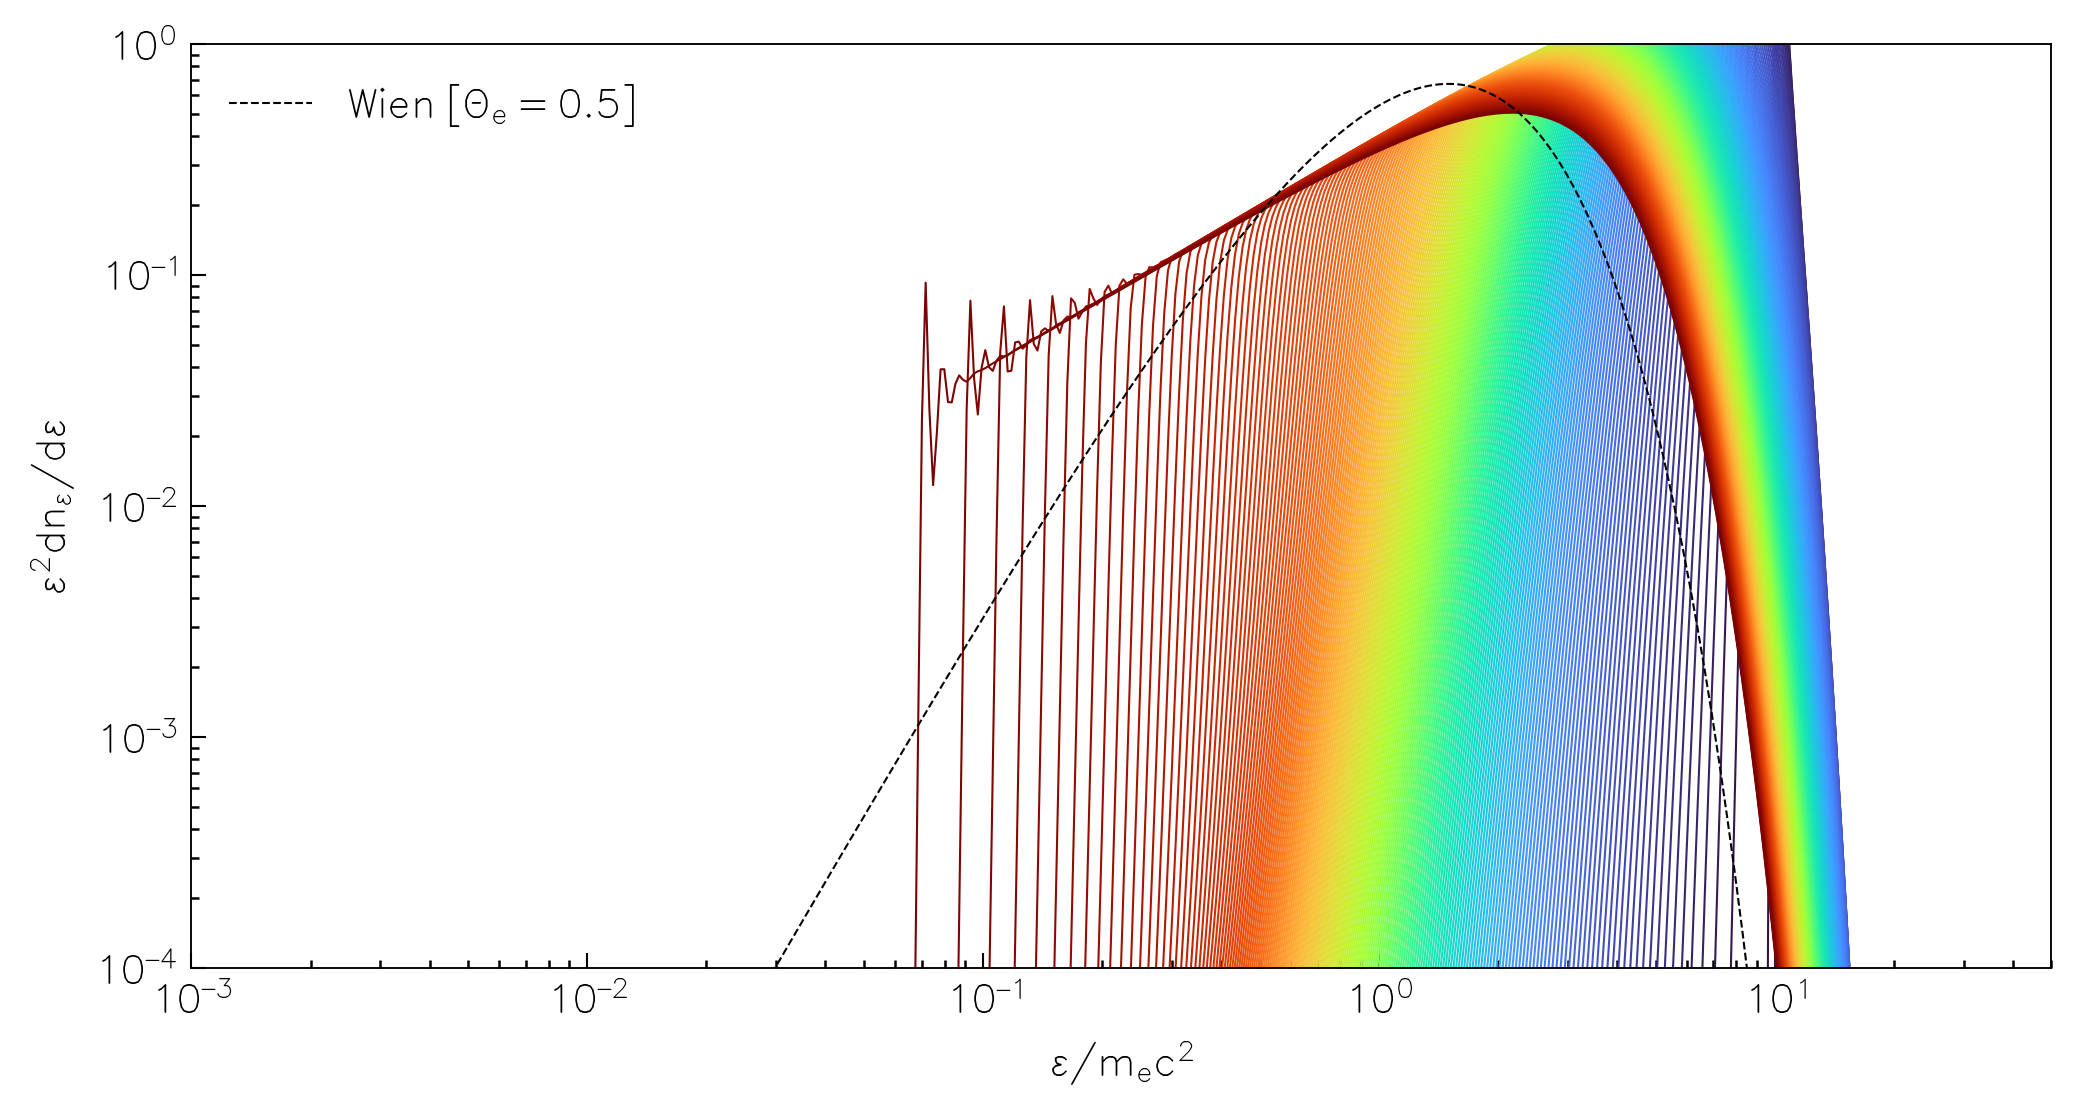

In [28]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = plt.subplot(111)

for n, c in zip(n0_arr, mpl.colormaps["turbo"](np.linspace(0, 1, len(n0_arr)))):
    ax.plot(e_arr, e_arr**3 * n / norm, c=c)

n_target = 1 / (np.exp(e_arr / T))
n_target /= np.trapz(n_target * e_arr**2, e_arr)
ax.plot(e_arr, e_arr**3 * n_target, "--", label=r"Wien [$\Theta_e=0.5$]")
ax.legend()
_ = ax.set(
    xscale="log",
    yscale="log",
    ylim=(1e-4, 1),
    xlim=(emin, emax),
    xlabel=r"$\varepsilon/m_e c^2$",
    ylabel=r"$\varepsilon^2dn_\varepsilon/d\varepsilon$",
)

Text(0.5, 0, '$t$')

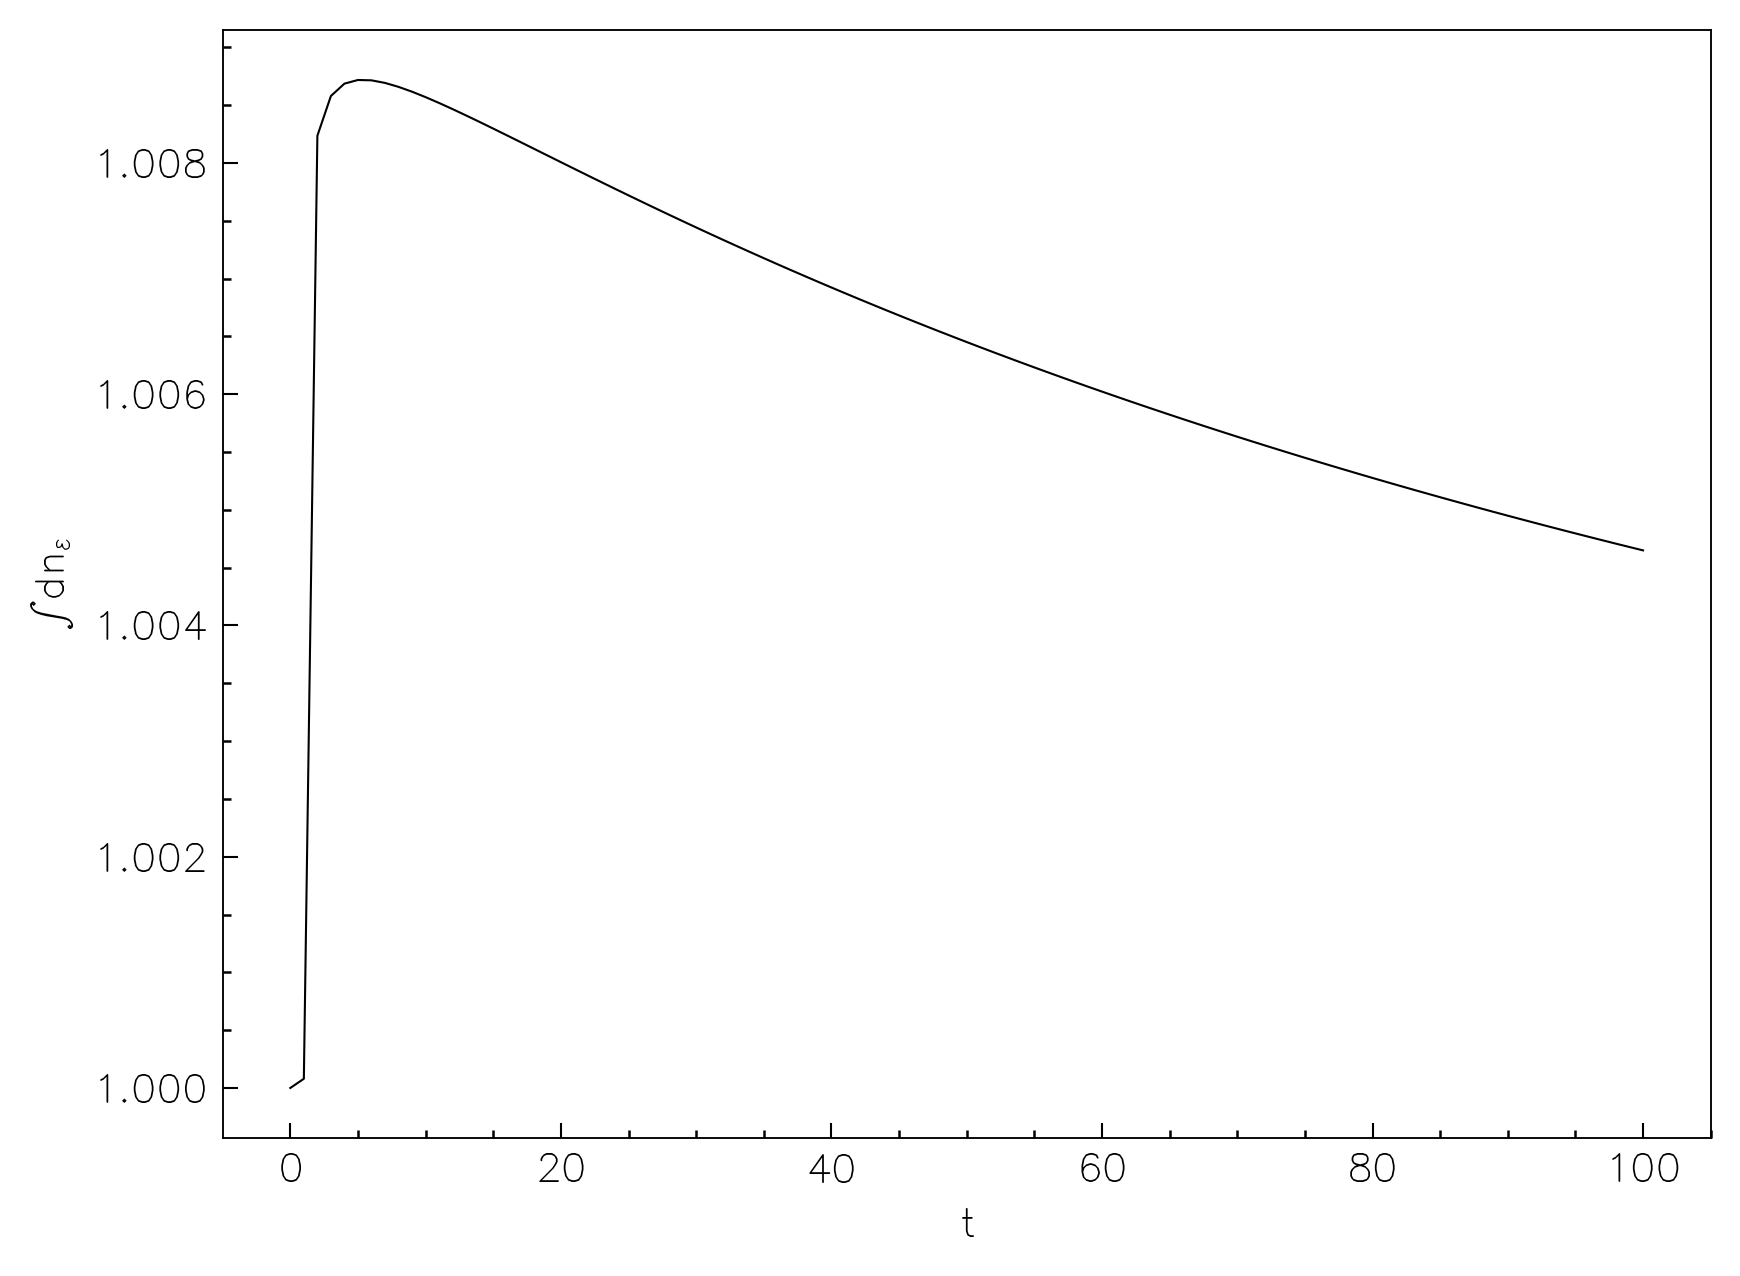

In [26]:
plt.plot([np.trapz(n * e_arr**2, e_arr) / norm for n in n0_arr])
plt.ylabel(r"$\int d n_\varepsilon$")
plt.xlabel(r"$t$")